EnvSpec(
│   id='MountainCarContinuous-v0',
│   entry_point='gymnasium.envs.classic_control.continuous_mountain_car:Continuous_MountainCarEnv',
│   reward_threshold=90.0,
│   nondeterministic=False,
│   max_episode_steps=999,
│   order_enforce=True,
│   autoreset=False,
│   disable_env_checker=False,
│   apply_api_compatibility=False,
│   kwargs={'render_mode': 'rgb_array'},
│   namespace=None,
│   name='MountainCarContinuous',
│   version=0,
│   additional_wrappers=(
│   │   WrapperSpec(name='EpisodeMonitor', entry_point='impls.utils.env_utils:EpisodeMonitor', kwargs=None),
│   ),
│   vector_entry_point=None
)

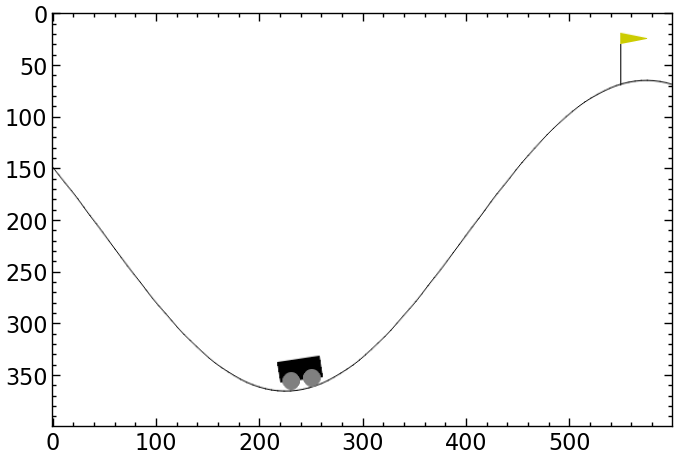

In [1]:
import os
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import matplotlib.pyplot as plt
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import numpy as np

plt.style.use(['science', 'notebook'])
import mediapy

import gymnasium as gym
from impls.utils.env_utils import EpisodeMonitor

mountain_car = gym.make("MountainCarContinuous-v0", render_mode='rgb_array') #gym.make("MountainCarContinuous-v0", render_mode='rgb_array')
mountain_car = EpisodeMonitor(mountain_car)
# [position, velocity]
obs, info = mountain_car.reset()
plt.imshow(mountain_car.render())
mountain_car.close()

GLOBAL_KEY = jax.random.key(42)

pprint(mountain_car.spec)

# Train Ground Truth Algorithm (SAC)

In [2]:
from impls.agents.sac import SACAgent, get_config
import flashbax as fbx

def train_loop(agent, train_iters, seed, env, gradient_steps):
    key = jax.random.key(seed)
    
    buffer = fbx.make_item_buffer(
            max_length=1_000_000,
            min_length=5_000,
            sample_batch_size=128,
            add_sequences=False
        )
    init_sample = {"observations": np.zeros_like(env.observation_space.sample()),
                   "next_observations": np.zeros_like(env.observation_space.sample()),
                   "actions": np.zeros_like(env.action_space.sample()),
                   "rewards": np.array(0.0),
                   "masks": np.array(0.0)}
    state = buffer.init(init_sample)
    
    pbar = tqdm(range(train_iters + 1), colour='green')
    observation, info = env.reset()
    
    def gradient_loop(carry, _):
        buffer_key, agent = carry
        buffer_key, sample_key, next_key = jax.random.split(buffer_key, 3)
        
        batch = jax.jit(buffer.sample)(state, sample_key).experience
        agent, _ = agent.update(batch)
        
        return (next_key, agent), None
    
    for step in pbar:
        key = jax.random.fold_in(key, step)
        key, sample_key = jax.random.split(key, 2)
        if step <= 15_000:
            action = env.action_space.sample()
            action = action + jax.random.normal(sample_key, shape=action.shape)
        else:
            action = agent.sample_actions(seed=sample_key, observations=observation, temperature=0.0)
        
        cur_obs = observation
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = jax.jit(buffer.add)(state, {"observations": cur_obs, "actions": action, "next_observations": observation,
                           "rewards": reward, "masks":  1 - float(done)})
        if step > 15_000:
            (_, agent), _ = jax.lax.scan(gradient_loop, init=(sample_key, agent), length=gradient_steps)

        if done:
            pbar.set_postfix({"latest_ep_reward": info['episode']['return']})
            observation, info = env.reset()
            
    env.close()
    return agent

sac_config = get_config()
sac = SACAgent.create(
    seed=100,
    ex_observations=obs,
    ex_actions=mountain_car.action_space.sample(),
    config=sac_config
)

trained_sac = train_loop(sac, train_iters=25_000, seed=44, env=mountain_car, gradient_steps=128)

2025-02-06 17:27:33.199427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738852053.221902 2745021 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738852053.228783 2745021 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/25001 [00:00<?, ?it/s]

In [84]:
def evaluation_loop(agent, env, key, num_trajs=1):
    render = []
    traj = []
    for traj_idx in range(num_trajs):
        observation, info = env.reset()
        done = False
        cur_traj = []
        while not done:
            action = agent.sample_actions(seed=key, observations=observation, temperature=0.0)
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if traj_idx == 0:
                render.append(env.render())
            cur_traj.append(np.concatenate([observation, action]))
        traj.append(np.stack(cur_traj))
    return render, traj

render, traj = evaluation_loop(trained_sac, mountain_car, key=jax.random.split(GLOBAL_KEY, 2)[1])
mediapy.show_video(
    render
)

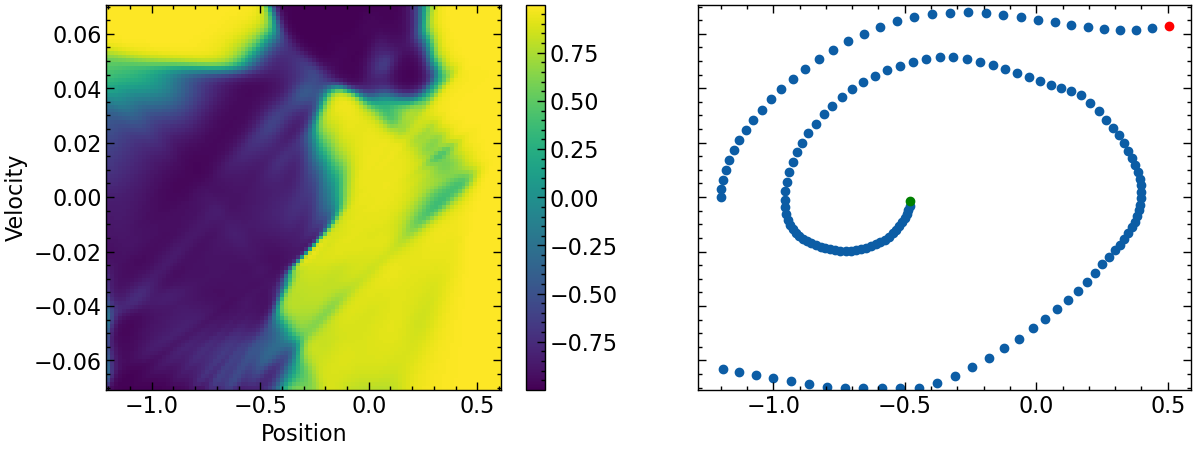

In [85]:
def plot_value_function_env(env, key, num_grid=100, agent=None, traj=None):
    positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_grid)
    velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_grid)
    grid = np.array(np.meshgrid(positions, velocities)).T.reshape(-1, 2)
    if agent is None:
        action = np.random.uniform(low=-1.0, high=1.0, size=(grid.shape[0], ))
    else:
        action = agent.sample_actions(seed=key, observations=grid, temperature=0.0)
    critic_values = jax.device_get(jnp.min(agent.network.select('critic')(grid, action), axis=0))

    x, y = np.meshgrid(positions, velocities)
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 5), sharey=True)
    
    ax[0].set_xlabel("Position")
    ax[0].set_ylabel("Velocity")
    pcm = ax[0].pcolormesh(x, y, action.reshape(num_grid, num_grid), cmap='viridis')
    fig.colorbar(pcm, ax=ax[0])
    
    ax[1].scatter(traj[1:-1, 0], traj[1:-1, 1])
    ax[1].scatter(traj[-1, 0], traj[-1, 1], color='red')
    ax[1].scatter(traj[0, 0], traj[0, 1], color='green')
        
    
plot_value_function_env(mountain_car, GLOBAL_KEY, agent=trained_sac, traj=traj[0])

In [93]:
import flashbax as fbx
import jax.numpy as jnp

def feature_vector(position, action, velocity):
    f1 = jnp.array([position])
    f2 = jnp.array([velocity])
    f3 = jnp.array([position ** 2])
    f4 = jnp.array([velocity ** 2])
    f5 = jnp.array([position * velocity])
    f6 = -0.1 * action ** 2
    f7 = action * position
    f8 = action * velocity
    f9 = 0.45 - jnp.array([position])
    f10 = jnp.sign(action)
    f11 = (f2 ** 2) / 2.0
    return jnp.stack([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11]).squeeze()

# For SFS
def collect_trajectories(agent, env, seed, num_trajs=2):
    key = jax.random.key(seed)
    
    buffer = fbx.make_item_buffer(
            max_length=num_trajs * 200,
            min_length=200,
            sample_batch_size=128,
            add_sequences=False
        )
    init_sample = {"observations": np.zeros_like(env.observation_space.sample()),
                   "next_observations": np.zeros_like(env.observation_space.sample()),
                   "actions": np.zeros_like(env.action_space.sample()),
                   "obs_feature": np.zeros(shape=11),
                   "next_obs_feature": np.zeros(shape=11),
                   "next_atcions": np.zeros_like(env.action_space.sample()),
                    "rewards": np.array(0.0),
                    "masks": np.array(0.0)}
    state = buffer.init(init_sample)
    
    for _ in range(num_trajs):
        observation, info = env.reset()
        done = False
        while not done:
            action = agent.sample_actions(seed=key, observations=observation, temperature=0.0)
            cur_obs = observation
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_action = agent.sample_actions(seed=key, observations=observation, temperature=0.0) # bad way, but let it be...
            state = jax.jit(buffer.add)(state, {"observations": cur_obs, "actions": action, "next_observations": observation,
                                                "obs_feature": feature_vector(cur_obs[0], action, cur_obs[1]),
                                                "next_obs_feature": feature_vector(observation[0], next_action, observation[1]), 
                                                "next_actions": next_action,
                           "rewards": reward, "masks":  1 - float(done)})
                
    return state, buffer

sac_trained_state_rb, sac_trained_rb = collect_trajectories(sac, mountain_car, seed=100500, num_trajs=2)

# SFs

In [95]:
class PenalizeLeftMovementCar(gym.Env):
    def __init__(self, custom_reward=False, **kwargs):
        self.inner_env = gym.make("MountainCarContinuous-v0", **kwargs)
        self.observation_space = self.inner_env.observation_space
        self.action_space = self.inner_env.action_space
        self.render_mode = kwargs.get('render_mode') if not None else 'rgb_array'
        self.spec = self.inner_env.spec
        self.custom_reward = custom_reward
        self.num_bad_acts = 0
        
    def reset(self, *, seed = None, options = None):
        return self.inner_env.reset()
    
    def step(self, action):
        observation, reward, terminated, truncated, info = self.inner_env.step(action)
        # if self.custom_reward:
        #     reward 
        #     # if action < 0:
        #     #     reward -= 0.5
        #     #     self.num_bad_acts += 1
        return observation, reward, terminated, truncated, info
    
    def render(self):
        return self.inner_env.render()
    
    def close(self):
        return self.inner_env.close()

env = PenalizeLeftMovementCar(render_mode='rgb_array', custom_reward=False) # at first check same reward function -0.1 * action^2
env.reset()

(array([-0.40662688,  0.        ], dtype=float32), {})

# Successor Features

In [96]:
import flax
import flax.linen as nn
import flax.struct
from impls.utils.flax_utils import ModuleDict, TrainState
from impls.utils.networks import ensemblize
import optax
from typing import Any
from jaxtyping import *


class PsiNet(flax.linen.Module):
    hidden_layers: list[int] = (256, 256)
    
    @nn.compact
    def __call__(self, state, action):
        x = jnp.concatenate([state, action], -1)
        for idx, num_feat in enumerate(self.hidden_layers):
            sf = nn.Dense(num_feat)(x)
            if idx != len(self.hidden_layers) - 1:
                sf = jax.nn.relu(sf)
        return sf
    
class SFAgent(flax.struct.PyTreeNode):
    rng: Key
    network: TrainState
    target_network: TrainState
    tau: float = 0.005
    gamma: float = 0.99
    
    @jax.jit
    def update(self, batch):
        def loss_fn(params):
            next_feat = self.target_network(batch['next_observations'], batch['next_action'])
            target_feat = batch['feature'] + self.gamma * batch['mask'][:, None] * next_feat
            q1, q2 = self.network(batch['obs'], batch['action'], params=params)
            loss = ((q1 - target_feat) ** 2 + (q2 - target_feat) ** 2)
            return loss.mean(), {}
        
        new_state, info = self.network.apply_loss_fn(loss_fn=loss_fn)
        new_target = self.target_update(new_state, self.target_network)
        return self.replace(network=new_state, target_network=new_target), info
    
    def target_update(self, network, target_net):
        new_target_params = jax.tree_util.tree_map(
            lambda p, tp: p[0] * self.tau + tp * (1 - self.tau),
            network.params,
            target_net.params,
        )
        return target_net.replace(params=new_target_params)

    @classmethod
    def create(cls,
            seed,
            ex_obs,
            ex_actions,
        ):
        
        key = jax.random.PRNGKey(seed)
        key, net_key = jax.random.split(key, 2)
        
        psi_net_def = ensemblize(PsiNet, num_qs=2)(hidden_layers=(512, 512, 11))
        target_psi_net_def = PsiNet(hidden_layers=(512, 512, 11))
        
        network_tx = optax.adam(learning_rate=1e-4)
        net_params = psi_net_def.init(net_key, ex_obs, ex_actions)['params'] 
        net_state = TrainState.create(
            model_def=psi_net_def,
            params=net_params,
            tx=network_tx
        )
        target_net_state = TrainState.create(
            model_def=target_psi_net_def,
            params=jax.tree.map(lambda _: _[0], net_params)
        )
        return cls(rng=key, network=net_state, target_network=target_net_state)
    
    def compute_sfs(self, *args):
        return  jnp.min(self.network(*args), axis=0)
    
agent = SFAgent.create(
    42,
    env.observation_space.sample(),
    env.action_space.sample()
)

In [ ]:
def train_sfs_loop(agent, train_iters, seed, gradient_steps, buffer, state_rb):
    key = jax.random.key(seed)
    
    pbar = tqdm(range(train_iters + 1), colour='green')
    
    def gradient_loop(carry, _):
        buffer_key, agent = carry
        buffer_key, sample_key, next_key = jax.random.split(buffer_key, 3)
        
        batch = jax.jit(buffer.sample)(state_rb, sample_key).experience
        agent, _ = agent.update(batch)
        
        return (next_key, agent), None
    
    for step in pbar:
        key = jax.random.fold_in(key, step)
        key, sample_key = jax.random.split(key, 2)
        
        (_, agent), _ = jax.lax.scan(gradient_loop, init=(sample_key, agent), length=gradient_steps)
        
    return agent

In [35]:
positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 100)

grid = np.array(np.meshgrid(positions, velocities)).T.reshape(-1, 2)
action = np.random.uniform(low=-1.0, high=1.0, size=(grid.shape[0], )) #np.linspace(-1, 1, 100)[:, None]#

psi_values = agent.compute_sfs(grid, action[:, None])
# Test
test_w_sign = np.zeros(11)
test_w_sign[1] = 1.0#np.array([1.0, 1.0])
features = feature_vector(grid[:, 0], action, grid[:, 1]).T
test_rewards = (features @ test_w_sign).reshape(-1, 1)

psi_values = (psi_values @ test_w_sign).reshape(-1, 1)

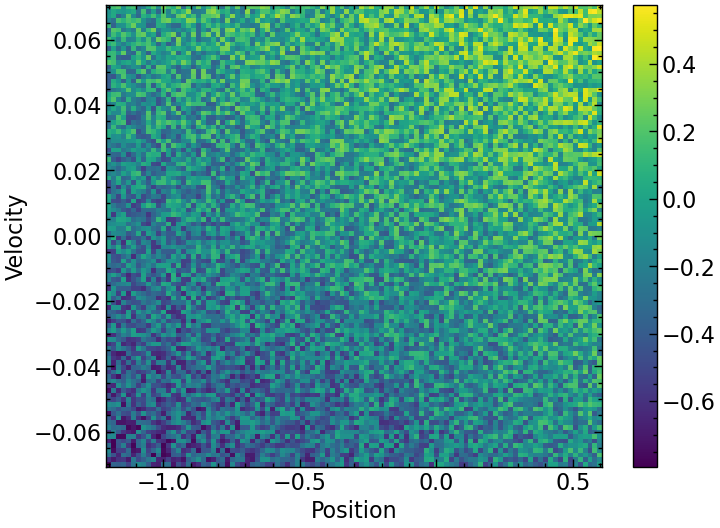

In [36]:
fig, ax = plt.subplots()
x, y = np.meshgrid(positions, velocities)
plt.pcolormesh(x, y, psi_values.reshape(100, 100), cmap='viridis')
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.colorbar()

In [26]:
from tqdm.auto import tqdm

pbar = tqdm(range(10_000), colour='green')
for i in pbar:
    sample_key = jax.random.fold_in(GLOBAL_KEY, i)
    batch = jax.jit(buffer.sample)(state, sample_key)
    agent, info = agent.update(batch.experience)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [39]:
psi_values = agent.compute_sfs(grid, action[:, None])
test_w_sign = np.zeros(11)
test_w_sign[9] = 1.0
psi_values = (psi_values @ test_w_sign).reshape(-1, 1)

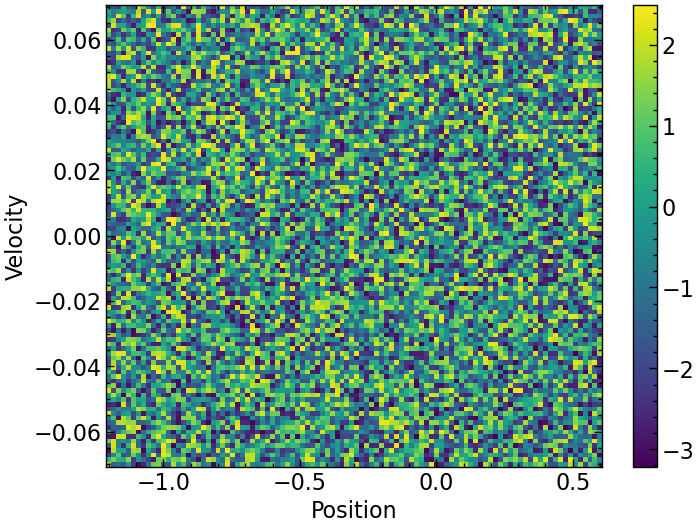

In [40]:
fig, ax = plt.subplots()
x, y = np.meshgrid(positions, velocities)
plt.pcolormesh(x, y, psi_values.reshape(100, 100), cmap='viridis')
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.colorbar()